## Import Packages

In [304]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import rankdata
import os
import matplotlib as mpl
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.svm import SVC
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from combat.pycombat import pycombat
from imblearn.over_sampling import SMOTE
import warnings
from pandas.core.common import SettingWithCopyWarning
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, chi2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Functions

In [305]:
def calculate_classification_metrics_multinomial(y_true, y_pred):
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:", accuracy)

    # Calculate precision, recall, and F1-score for each class
    precision_micro = precision_score(y_true, y_pred, average='micro')
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    print("Precision (Micro):", precision_micro)
    print("Precision (Macro):", precision_macro)
    print("Recall (Micro):", recall_micro)
    print("Recall (Macro):", recall_macro)
    print("F1-Score (Micro):", f1_micro)
    print("F1-Score (Macro):", f1_macro)
    
def calculate_classification_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:", accuracy)
    precision = precision_score(y_true, y_pred, average='weighted')
    print("Precision:", precision)
    recall = recall_score(y_true, y_pred, average='weighted')
    print("Recall:", recall)
    f1 = f1_score(y_true, y_pred, average='weighted')
    print("F1-Score:", f1)
    
def load(file_path):
    data = pd.read_csv(file_path, index_col=0)
    return data

def predict_high_probability_labels(classifier, X_unlabelled_merged, threshold=0.6):
    pseudo_labels_proba = classifier.predict_proba(X_unlabelled_merged)
    class_labels = classifier.classes_
    predicted_labels = []
    high_prob_df = pd.DataFrame(columns=['resistance_label'])
    for i, sample_probs in enumerate(pseudo_labels_proba):
        sample_name = X_unlabelled_merged.index[i]
        predicted_label_index = np.argmax(sample_probs)
        predicted_label = class_labels[predicted_label_index]

        if max(sample_probs) > threshold:
            predicted_labels.append(predicted_label)
            high_prob_df.loc[sample_name] = [predicted_label]
    
    return high_prob_df

def new_column_value(row_name):
    if 'TCGA' in row_name:
        return 'TCGA'
    else:
        return 'GDSC'
    
warnings.filterwarnings("ignore", category=RuntimeWarning, message=".*slice*")
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

# Building a classifier with pseudo-labelled data

In [306]:
os.chdir('/Users/amyhayward/Documents/BIOINFORMATICS MSC/Project/FINAL_FILES')

## 1. Upload Data

#### TCGA gene expression data and mutation matrix (unlabelled)

In [307]:
X_unlabelled_exp = load("X_UNLABELLED_EXP_TALA.csv")
X_unlabelled_mut = load("X_UNLABELLED_MUT_TALA.csv")

#### Cell line expression, mutation matrix and labels (train)

In [308]:
X_train_exp = load("X_TRAIN_MATCH_TALA.csv")
X_train_mut = load("TRAIN_MATRIX_TALA.csv")
y_train = load("Y_TRAIN_AH_TALA.csv")
y_train = y_train['resistance_label']

#### Cell line expression data, mutation matrix and labels (test)

In [309]:
X_test_exp = load("X_TEST_MATCH_TALA.csv")
X_test_mut = load("TEST_MATRIX_TALA.csv")
y_test = load("y_TEST_AH_TALA.csv")
y_test = y_test['resistance_label']

## 2. Batch correction (TCGA and cell line expression(train)) using PyComBat 

#### Merge data frames

In [310]:
df_expression = pd.concat([X_train_exp, X_unlabelled_exp],join="inner",axis=0)

#### PCA before batch correction

In [311]:
df_copy = df_expression.copy()
df_copy.index = df_expression.index.astype(str)

df_copy['batch'] = df_copy.index.map(new_column_value)

In [392]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.express as px

numeric_df = df_copy.drop(columns=['batch'])

pca = PCA(n_components=2)
components = pca.fit_transform(numeric_df) 

fig = px.scatter(components, x=0, y=1, color=df_copy['batch'],
                 title="PCA plot before batch correction (Talazoparib)",
                 labels={'0': 'PC1', '1': 'PC2'},
                 color_discrete_map={"tcga": "blue", "GDSC": "red"},
                 template="plotly",
                 hover_name=df_copy.index, 
                 #text=df_copy['batch'],  
                 width=800, height=600
                )

fig.update_layout(legend_title_text='Labels', legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1))
fig.show()

#### Run PyComBat

In [313]:
ds1 = numeric_df[numeric_df.index.str.contains('TCGA')]
ds2 = numeric_df[~numeric_df.index.str.contains('TCGA')]
ds1 = ds1.T
ds2 = ds2.T

df_expression = pd.concat([ds1, ds2],join="inner",axis=1)

batch = []
datasets = [ds1, ds2]
for j in range(len(datasets)):
    batch.extend([j for _ in range(len(datasets[j].columns))])

df_corrected = pycombat(df_expression,batch)

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


In [314]:
df_corrected = df_corrected.T

#### PCA after batch correction

In [393]:
pca = PCA(n_components=2)
components = pca.fit_transform(df_corrected)

fig = px.scatter(components, x=0, y=1, color=df_copy['batch'], #label cols
                 title="PCA plot after batch correction (Talazoparib)",
                 labels={'0': 'PC1', '1': 'PC2'},
                 color_discrete_map={"tcga": "blue", "GDSC": "red"},
                 template="plotly",
                 hover_name=df_corrected.index,
                 #text=df_copy['batch'],
                 width=800, height=600
                )

fig.update_layout(legend_title_text='Labels', legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1))
fig.show()

#### Split df_corrected so that analysis can be done on labelled data

In [316]:
X_unlabelled_bc = df_corrected[df_corrected.index.str.contains('TCGA')]
X_train_bc = df_corrected[~df_corrected.index.str.contains('TCGA')]

In [317]:
for_mut_counts = X_train_mut.copy()

for_mut_counts['SumMutationCount'] = for_mut_counts.sum(axis=1)
for_mut_counts['resistance_label'] = y_train

fig = px.bar(for_mut_counts, x=for_mut_counts.index, y='SumMutationCount', color='resistance_label',
             labels={'index': 'Sample', 'SumMutationCount': 'Sum Mutation Count'},
             title='Sum Mutation Counts by Cell Line',
             template='plotly',
             height=500)

fig.show()

## 3. Supervised Feature Selection for Mutation Train Data

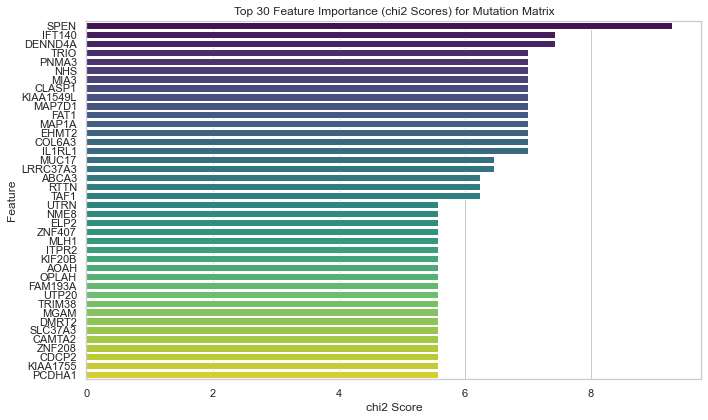

In [318]:
k_best = SelectKBest(score_func=chi2, k=30) 
X_train_mut_selected = k_best.fit_transform(X_train_mut, y_train)
scores_mut = k_best.scores_
scores_df_mut = pd.DataFrame({'Feature': X_train_mut.columns, 'Score': scores_mut})
scores_df_mut = scores_df_mut.sort_values(by='Score', ascending=False)

top_n = 40
top_features_mut = scores_df_mut.nlargest(top_n, 'Score')

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Feature', data=top_features_mut, palette="viridis")
plt.xlabel('chi2 Score')
plt.ylabel('Feature')
plt.title('Top 30 Feature Importance (chi2 Scores) for Mutation Matrix')
plt.tight_layout()
plt.show()

In [319]:
top_indices_mut = k_best.get_support(indices=True)
X_train_mut_top50 = X_train_mut.iloc[:, top_indices_mut]
X_test_mut_top50 = X_test_mut.iloc[:, top_indices_mut]
X_unlabelled_mut_top50 = X_unlabelled_mut.iloc[:, top_indices_mut]

## 4. Supervised Feature Selection for Gene Expression Training Data (DESeq in R)

#### Load DESeq Results - More Resistant vs Intermediate

In [320]:
siggenes_df_more = load('DESeq2_results-tala-res_more_vs_int.csv')
siggenes_df_more = siggenes_df_more.T

In [321]:
subset_columns_more = siggenes_df_more.columns[siggenes_df_more.loc['padj'] < 0.05]
subset_df_more = siggenes_df_more[subset_columns_more]

,ABCD1,ACOT1,ACTR2,ACVR1C,ADAM8,AHDC1,ALDH3B2,AP1S3,AREG,ARHGAP42,...,ZNF362,ZNF510,ZNF536,ZNF556,ZNF557,ZNF646,ZNF749,ZNF750,ZNF81,ZNF846
log2FoldChange,5.184620,4.134854,4.068980,-5.110281,1.049784,-3.664902,-3.331606,4.336815,7.044062e+00,-5.897118,...,4.431935,3.572204,4.666258,6.866095e+00,4.453585,-3.936295,9.783741e+00,5.646973,5.557696,1.134653e+01
pvalue,0.000035,0.000002,0.000044,0.000186,0.000367,0.000009,0.000001,0.000167,1.926210e-07,0.000020,...,0.000141,0.000390,0.000042,3.895653e-07,0.000338,0.000219,1.127877e-10,0.000039,0.000008,5.957352e-15
padj,0.005940,0.000588,0.006975,0.018339,0.029030,0.002114,0.000480,0.017210,1.295989e-04,0.003739,...,0.015305,0.030158,0.006720,1.966551e-04,0.028067,0.020372,4.173709e-07,0.006456,0.001869,8.818072e-11


In [443]:
gene_to_search = 'CDKN2A'
if gene_to_search in subset_df_more.columns:
    log2fold_value = subset_df_more.loc['log2FoldChange', gene_to_search]
    print(f"Log2fold change value for '{gene_to_search}': {log2fold_value}")
else:
    print(f"The gene '{gene_to_search}' does not exist in the DataFrame.")

The gene 'CDKN2A' does not exist in the DataFrame.


In [322]:
subset_df_more_T = subset_df_more.T
sorted_results = subset_df_more_T.sort_values(by='log2FoldChange', ascending=False)

top_n = 40
top_upregulated = sorted_results[sorted_results['log2FoldChange'] > 0].iloc[:top_n]
top_downregulated = sorted_results[sorted_results['log2FoldChange'] < 0].iloc[:top_n]

top_genes = pd.concat([top_upregulated, top_downregulated])

top_genes['Regulation'] = ['Upregulated' if x > 0 else 'Downregulated' for x in top_genes['log2FoldChange']]

fig = px.bar(top_genes, x='log2FoldChange', y=top_genes.index,
             orientation='h', color='Regulation',
             title='Most Significant Log2 Fold Changes in the More Resistant Cell Lines vs Intermediate (Talazoparib)')
fig.update_layout(xaxis_title='Log2 Fold Change', yaxis_title='Gene ID', height=800, width=1000)
#fig.update_layout(height=top_n * 30)
fig.show()

#### Load DESeq Results - Less Resistant vs Intermediate

In [324]:
siggenes_df_less = load('DESeq2_results-tala-res_less_vs_int.csv')
siggenes_df_less = siggenes_df_less.T

In [325]:
subset_columns_less = siggenes_df_less.columns[siggenes_df_less.loc['padj'] < 0.05]
subset_df_less = siggenes_df_less[subset_columns_less]

,ABCG1,ADAM8,ADRA1D,AHDC1,AHI1,ANKRD23,APC,ARAP3,ARL4C,ASS1,...,ZNF266,ZNF341,ZNF513,ZNF536,ZNF556,ZNF639,ZNF767,ZNF81,ZNF862,ZNF880
log2FoldChange,4.882170,1.333136,-3.697186,-3.796823,-2.593704,-1.848612,-5.538713,-0.707643,4.862971,1.528616,...,4.133705,-0.835265,-3.103021,6.316094e+00,5.289818,4.612139,5.550854,5.573104,4.412617,5.247305
pvalue,0.000209,0.000014,0.000275,0.000010,0.000300,0.000452,0.000247,0.000484,0.000352,0.000366,...,0.000345,0.000174,0.000003,8.569340e-08,0.000163,0.000013,0.000009,0.000016,0.000239,0.000298
padj,0.025950,0.004363,0.030862,0.003874,0.032130,0.041800,0.028670,0.043748,0.035768,0.036311,...,0.035468,0.023206,0.002079,1.585542e-04,0.022172,0.004363,0.003790,0.004510,0.028294,0.032130


In [444]:
gene_to_search = 'CDKN2A'
if gene_to_search in subset_df_less.columns:
    log2fold_value = subset_df_less.loc['log2FoldChange', gene_to_search]
    print(f"Log2fold change value for '{gene_to_search}': {log2fold_value}")
else:
    print(f"The gene '{gene_to_search}' does not exist in the DataFrame.")

The gene 'CDKN2A' does not exist in the DataFrame.


In [326]:
subset_df_less_T = subset_df_less.T
sorted_results = subset_df_less_T.sort_values(by='log2FoldChange', ascending=False)

top_n = 40
top_upregulated = sorted_results[sorted_results['log2FoldChange'] > 0].iloc[:top_n]
top_downregulated = sorted_results[sorted_results['log2FoldChange'] < 0].iloc[:top_n]

top_genes = pd.concat([top_upregulated, top_downregulated])

top_genes['Regulation'] = ['Upregulated' if x > 0 else 'Downregulated' for x in top_genes['log2FoldChange']]

fig = px.bar(top_genes, x='log2FoldChange', y=top_genes.index,
             orientation='h', color='Regulation',
             title='Most Significant Log2 Fold Changes in the Less Resistant Cell Lines vs Intermediate (Talazoparib)')
fig.update_layout(xaxis_title='Log2 Fold Change', yaxis_title='Gene ID', height=800, width=1000)
#fig.update_layout(height=top_n * 30)
fig.show()

#### Load DESeq Results - Less Resistant vs More Resistant

In [328]:
siggenes_df_lvm = load('DESeq2_results-tala-res_more_vs_less_res.csv')
siggenes_df_lvm = siggenes_df_lvm.T

In [329]:
subset_columns_lvm = siggenes_df_lvm.columns[siggenes_df_lvm.loc['padj'] < 0.05]
subset_df_lvm = siggenes_df_lvm[subset_columns_lvm]

,ACTN4,ACTR2,AEBP2,ALDH3B2,ANO1,ANP32B,AP1S3,APC,ARL13B,ATR,...,ZNF503,ZNF557,ZNF584,ZNF596,ZNF749,ZNF791,ZNF800,ZNF827,ZNF841,ZNF846
log2FoldChange,2.602149,4.580752,4.335551,-2.868828,4.740693,4.057723,5.167716,7.371706e+00,4.916854,3.738313,...,4.169215,7.867447e+00,4.809944,-2.794902,9.620173e+00,2.496408,3.967173,6.436108,6.990994e+00,1.039676e+01
pvalue,0.000675,0.000062,0.000208,0.000006,0.000282,0.000355,0.000149,6.521763e-08,0.000148,0.000064,...,0.000155,7.554058e-10,0.000170,0.000630,1.855511e-08,0.000526,0.000426,0.000003,5.766472e-07,1.161494e-09
padj,0.049428,0.009826,0.022977,0.002072,0.028436,0.033688,0.018003,6.306110e-05,0.018003,0.009878,...,0.018276,2.767134e-06,0.019762,0.047856,2.691232e-05,0.042192,0.036466,0.001427,2.987033e-04,2.767134e-06


In [445]:
gene_to_search = 'CDKN2A'
if gene_to_search in subset_df_lvm.columns:
    log2fold_value = subset_df_lvm.loc['log2FoldChange', gene_to_search]
    print(f"Log2fold change value for '{gene_to_search}': {log2fold_value}")
else:
    print(f"The gene '{gene_to_search}' does not exist in the DataFrame.")

Log2fold change value for 'CDKN2A': -3.46545585615074


In [330]:
subset_df = pd.concat([subset_df_less, subset_df_more, subset_df_lvm], axis=1)

In [331]:
subset_columns = subset_df.columns[subset_df.loc['padj'] < 0.05]

In [360]:
subset_df_lvm_T = subset_df_lvm.T
sorted_results = subset_df_lvm_T.sort_values(by='log2FoldChange', ascending=False)

top_n = 20
top_upregulated = sorted_results[sorted_results['log2FoldChange'] > 0].iloc[:top_n]
top_downregulated = sorted_results[sorted_results['log2FoldChange'] < 0].iloc[:top_n]

top_genes = pd.concat([top_upregulated, top_downregulated])

top_genes['Regulation'] = ['Upregulated' if x > 0 else 'Downregulated' for x in top_genes['log2FoldChange']]

fig = px.bar(top_genes, x='log2FoldChange', y=top_genes.index,
             orientation='h', color='Regulation',
             title='More Resistant vs Less Resistant (Talazoparib)')
fig.update_layout(xaxis_title='Log2 Fold Change', yaxis_title='Gene ID', height=600, width=800)
#fig.update_layout(height=top_n * 30)
fig.show()

## 5. Scale Expression Training and Test Data, Subsetting to DEGs

#### Merge batch corercted expression and mutation data (x_train)

In [334]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(X_train_bc)
X_train_scaled = pd.DataFrame(scaled_train, columns=X_train_bc.columns, index=X_train_bc.index)

In [335]:
X_train_DEGs = X_train_scaled[subset_columns]

In [336]:
pca = PCA(n_components=2)
components = pca.fit_transform(X_train_DEGs)

fig = px.scatter(components, x=0, y=1, color=y_train, #label cols
                 title="PCA Training Data with DEGs Feature Selection",
                 labels={'0': 'PC1', '1': 'PC2'},
                 color_discrete_map={"less resistance": "blue", "more resistance": "red", "less resistant": "green"},
                 template="plotly",
                 hover_name=X_train_DEGs.index,
                 #text=df_copy['batch'],
                 width=600, height=500
                )

fig.update_layout(legend_title_text='Labels', legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1))
fig.show()

In [337]:
X_train_merged = X_train_DEGs.merge(X_train_mut_top50, left_index=True, right_index=True, how='inner')

#### Merge batch corercted expression and mutation data (x_test)

In [338]:
scaled_test = scaler.fit_transform(X_test_exp)
X_test_scaled = pd.DataFrame(scaled_test, columns=X_test_exp.columns, index=X_test_exp.index)

In [339]:
X_test_DEGs = X_test_scaled[subset_columns]

In [340]:
pca = PCA(n_components=2)
components = pca.fit_transform(X_test_DEGs)

fig = px.scatter(components, x=0, y=1, color=y_test,
                 title="PCA Test Data with DEGs Feature Selection",
                 labels={'0': 'PC1', '1': 'PC2'},
                 color_discrete_map={"less resistance": "blue", "more resistance": "red", "less resistant": "green"},
                 template="plotly",
                 hover_name=X_test_DEGs.index,
                 #text=df_copy['batch'],
                 width=600, height=500
                )

fig.update_layout(legend_title_text='Labels', legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1))
fig.show()

In [341]:
X_test_merged = X_test_DEGs.merge(X_test_mut_top50, left_index=True, right_index=True, how='inner')

#### Merge batch corercted expression and mutation data (TCGA)

In [342]:
scaled_unlabelled = scaler.fit_transform(X_unlabelled_bc)
X_unlabelled_scaled = pd.DataFrame(scaled_unlabelled, columns=X_unlabelled_bc.columns, index=X_unlabelled_bc.index)

In [343]:
X_unlabelled_DEGs = X_unlabelled_scaled[subset_columns]

In [344]:
X_unlabelled_merged = X_unlabelled_DEGs.merge(X_unlabelled_mut_top50, left_index=True, right_index=True, how='inner')

## 6. Classification

### Multinomial Logistic Regression - Gene Expression Only

In [345]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=10000)

classifier.fit(X_train_DEGs, y_train)

coefficients = classifier.coef_

#### Select coefficients > 0.08

In [346]:
threshold = 0.08
selected_features = X_train_DEGs.columns[coefficients[0] > threshold]

X_train_COEF = X_train_DEGs[selected_features]
X_test_COEF = X_test_DEGs[selected_features]
X_unlabelled_COEF = X_unlabelled_DEGs[selected_features]

In [366]:
mask = coefficients[0] > threshold

# Extract selected features' coefficients and names
selected_coeff_values = coefficients[0][mask]
selected_coeff_names = X_train_DEGs.columns[mask]

coeff_df = pd.DataFrame({'Features': selected_coeff_names, 'Coefficients': selected_coeff_values})

# Create a coefficient plot
fig = px.bar(coeff_df, x='Coefficients', y='Features', orientation='h')
fig.add_vline(x=0, line_dash='dash', line_color='gray')  # Add a vertical line at zero

fig.update_layout(
    title='Coefficient Plot for Selected Features > 0.08 (Talazoparib)',
    xaxis_title='Coefficient Values',
    yaxis_title='Selected Features',
    height=600, width=800
)

fig.show()

In [371]:
import plotly.graph_objects as go

mask = coefficients[0] > threshold

selected_coeff_values = coefficients[0][mask]
selected_coeff_names = X_train_DEGs.columns[mask]

fig = go.Figure()

for feature, coeff_value in zip(selected_coeff_names, selected_coeff_values):
    fig.add_trace(go.Scatter(
        x=[coeff_value],
        y=[feature],
        mode='markers',
        marker=dict(size=14),
        name=feature
    ))

fig.update_layout(
    title='Selected Features > 0.08 (Talazoparib)',
    xaxis_title='Coefficient Values',
    yaxis_title='Selected Gene ID',
    xaxis=dict(showgrid=False),
    showlegend=False,
    height=600,
    width=600
)

fig.show()

#### Cross Validation

In [388]:
cv_scores = cross_val_score(classifier, X_train_COEF, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

error_rates = 1 - cv_scores

# Print error rates for each fold
for fold, error_rate in enumerate(error_rates, start=1):
    print(f"Fold {fold} Error Rate: {error_rate:.4f}")

# Calculate and print the mean error rate
mean_error_rate = error_rates.mean()
print("Mean Error Rate:", mean_error_rate)

Cross-Validation Scores: [0.75 0.25 1.   0.5  0.5 ]
Mean CV Score: 0.6
Fold 1 Error Rate: 0.2500
Fold 2 Error Rate: 0.7500
Fold 3 Error Rate: 0.0000
Fold 4 Error Rate: 0.5000
Fold 5 Error Rate: 0.5000
Mean Error Rate: 0.4


#### Generate Synthetic Samples with SMOTE

In [348]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(sampling_strategy='minority', k_neighbors=2, random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train_COEF, y_train)

# X_train_syn = pd.concat([X_train_COEF, X_resampled], ignore_index=False)
# y_train_syn = pd.concat([y_train, y_resampled], ignore_index=False)

In [349]:
# classifier.fit(X_train_syn, y_train_syn)

# cv_scores = cross_val_score(classifier, X_train_syn, y_train_syn, cv=5, scoring='accuracy')
# print("Cross-Validation Scores:", cv_scores)
# print("Mean CV Score:", cv_scores.mean())

#### Make Predictions on TCGA Data (Unlabelled Data)

In [350]:
classifier.fit(X_train_COEF, y_train)
high_prob_df = predict_high_probability_labels(classifier, X_unlabelled_COEF, threshold=0.5)

In [351]:
y_unlabelled_pseudo = high_prob_df['resistance_label']
y_train_combined = pd.concat([y_train, y_unlabelled_pseudo], axis=0)

In [352]:
psuedo_samples = high_prob_df.index
X_unlabelled_pseudo = X_unlabelled_COEF.loc[psuedo_samples]

In [390]:
y_series = pd.Series(y_unlabelled_pseudo)
class_percentages = y_series.value_counts(normalize=True) * 100
print("Percentage of each classification:")
print(class_percentages)

Percentage of each classification:
less resistant    89.641434
more resistant     6.374502
intermediate       3.984064
Name: resistance_label, dtype: float64


In [353]:
X_train_combined = pd.concat([X_train_COEF, X_unlabelled_pseudo], axis=0)

In [354]:
pca = PCA(n_components=2)
components = pca.fit_transform(X_train_combined)

fig = px.scatter(components, x=0, y=1, color=y_train_combined, #label cols
                 title="PCA Pseudo Predictions and Actual Labels (Talazoparib)",
                 labels={'0': 'PC1', '1': 'PC2'},
                 color_discrete_map={"intermediate": "yellow", "more_resistant": "red", "less resistant": "green"},
                 template="plotly",
                 hover_name=X_train_combined.index,
                 #text=df_copy['batch'],
                 width=800, height=600
                )

fig.update_layout(legend_title_text='Labels', legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1))
fig.show()

#### Re-train Classifier with Pseuso-Labels

In [355]:
classifier.fit(X_train_combined, y_train_combined)

LogisticRegression(max_iter=10000, multi_class='multinomial', solver='saga')

In [389]:
cv_scores = cross_val_score(classifier, X_train_combined, y_train_combined, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())
error_rates = 1 - cv_scores

# Print error rates for each fold
for fold, error_rate in enumerate(error_rates, start=1):
    print(f"Fold {fold} Error Rate: {error_rate:.4f}")

# Calculate and print the mean error rate
mean_error_rate = error_rates.mean()
print("Mean Error Rate:", mean_error_rate)

Cross-Validation Scores: [0.96363636 1.         0.96296296 0.90740741 0.92592593]
Mean CV Score: 0.9519865319865319
Fold 1 Error Rate: 0.0364
Fold 2 Error Rate: 0.0000
Fold 3 Error Rate: 0.0370
Fold 4 Error Rate: 0.0926
Fold 5 Error Rate: 0.0741
Mean Error Rate: 0.04801346801346802


#### Final Evaluation of Multinomial Logistic Regression Model

In [357]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_pred = classifier.predict(X_test_COEF)
    
calculate_classification_metrics_multinomial(y_test, y_pred)

Accuracy: 0.45
Precision (Micro): 0.45
Precision (Macro): 0.5
Recall (Micro): 0.45
Recall (Macro): 0.4444444444444444
F1-Score (Micro): 0.45
F1-Score (Macro): 0.4481481481481482


### Confusion Matrix

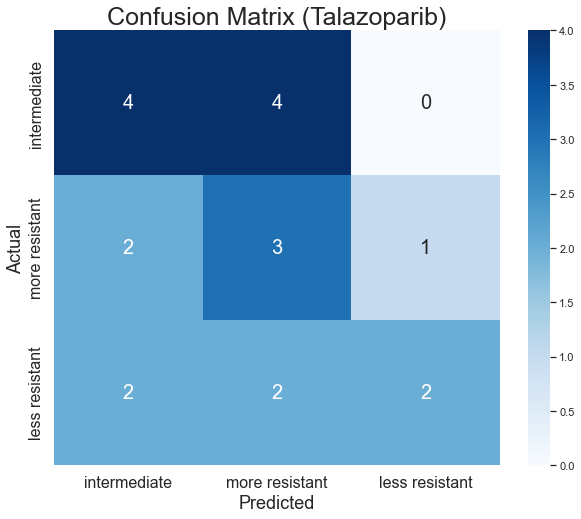

In [361]:
class_labels = ["intermediate", "more resistant", "less resistant"]
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels,
            annot_kws={"size": 20})
plt.title("Confusion Matrix (Talazoparib)", fontsize=25)
plt.xlabel("Predicted", fontsize =18)
plt.ylabel("Actual", fontsize = 18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

## 7. Mutation Landscape Plot for TCGA Data

In [416]:
selected_cols = ['ATM', 'BRCA1', 'BRCA2', 'RAD51B', 
                'RAD52', 'RAD54L', 'RAD50', 'RBBP8', 'MUS81', 'EME1', 
                  'TP53BP1', 'RIF1', 'BOD1L1']

subset_mut_matrix = X_unlabelled_mut[selected_cols]

,ATM,BRCA1,BRCA2,RAD51B,RAD52,RAD54L,RAD50,RBBP8,MUS81,EME1,TP53BP1,RIF1,BOD1L1
TCGA-3C-AAAU-01,0,0,0,0,0,0,0,0,0,0,0,0,0
TCGA-3C-AALJ-01,0,0,0,0,0,0,0,0,0,0,0,0,0
TCGA-3C-AALK-01,0,0,0,0,0,0,0,0,0,0,0,0,0
TCGA-4H-AAAK-01,0,0,0,0,0,0,0,0,0,0,0,0,0
TCGA-5L-AAT1-01,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-UU-A93S-01,0,0,0,0,0,0,0,0,0,0,0,0,0
TCGA-W8-A86G-01,0,0,0,0,0,0,0,0,0,0,0,0,0
TCGA-WT-AB41-01,0,0,0,0,0,0,0,0,0,1,0,0,0
TCGA-Z7-A8R5-01,0,0,0,0,0,0,0,0,0,0,0,0,0


In [418]:
combined_pseudo = pd.concat([y_unlabelled_pseudo, X_unlabelled_pseudo], axis=1)

In [419]:
pseudo_less = combined_pseudo[combined_pseudo['resistance_label'] == 'less resistant']
pseudo_more = combined_pseudo[combined_pseudo['resistance_label'] == 'more resistant']

In [420]:
matching_rows = subset_mut_matrix.index.intersection(pseudo_more.index)

In [423]:
subset_mut_matrix_more = subset_mut_matrix.loc[matching_rows]

,ATM,BRCA1,BRCA2,RAD51B,RAD52,RAD54L,RAD50,RBBP8,MUS81,EME1,TP53BP1,RIF1,BOD1L1
TCGA-A2-A04U-01,0,0,0,0,0,0,0,0,0,0,0,0,0
TCGA-A2-A04W-01,0,0,0,0,0,0,0,0,0,0,0,0,0
TCGA-AC-A62X-01,0,0,0,0,0,0,0,0,0,0,0,0,0
TCGA-AO-A1KR-01,0,1,0,0,0,0,0,0,0,0,0,0,0
TCGA-AR-A0TV-01,0,0,0,0,0,0,0,0,0,0,0,0,0
TCGA-BH-A5J0-01,0,0,0,0,0,0,0,0,0,0,0,0,0
TCGA-C8-A131-01,0,0,0,0,0,0,0,0,0,0,0,0,0
TCGA-C8-A134-01,0,0,0,0,0,0,0,0,0,0,0,0,0
TCGA-C8-A26W-01,0,0,0,0,0,0,0,0,0,0,0,0,0
TCGA-C8-A26X-01,0,0,0,0,0,0,0,0,0,0,0,0,0


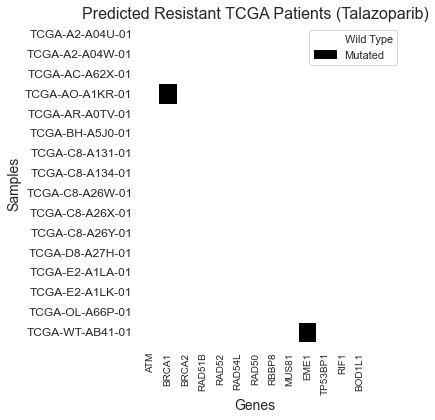

In [439]:
colors = ['#FFFFFF', '#000000'] 
labels = ['Wild Type', 'Mutated']

cmap = mcolors.ListedColormap(colors)

fig, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(subset_mut_matrix_more, cmap=cmap, ax=ax, cbar=False)

ax.set_xticklabels(subset_mut_matrix_more.columns, rotation=90, fontsize=10)
ax.set_yticklabels(subset_mut_matrix_more.index, fontsize=12)

ax.set_xlabel('Genes', fontsize=14)
ax.set_ylabel('Samples', fontsize=14)
ax.set_title('Predicted Resistant TCGA Patients (Talazoparib)', fontsize=16)

legend_patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(colors))]
ax.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.show()